# Notebook 04: Simple ML Classification

### Goal: Basic training a ML using a single feature/predictor/input and a single ML model

#### Reminder of Problem Statement

Before we jump into the ML, I want to remind you of the ML task we want to accomplish in the paper. 

1. Does this image contain a thunderstorm? <-- Classification
2. How many lightning flashes are in this image? <-- Regression

#### Background

For the training of machine learning we will use the [scikit-learn](https://scikit-learn.org/stable/) python package. Scikit-learn (also known as sklearn) has a wealth of resources for learning how to apply many ML methods. Futhermore, their documentation on any one method is extensive and very helpful. I encourage you to use their documentation if you want to use more that what we will show you in this tutorial. 

What is really nice about the sklearn package is that all of its models all work off the same syntax. In general this is how you use any of their models:

1. Create or load your input data. It must be of shape ```[n_samples,n_features]```. It is commonly written as ```X``` in all of the sklearn documentation. 
2. Create or load your output data. It must be of shape ```[n_samples]```. It is commonly written as ```y``` in all of the sklearn documentation 
3. Initialize your model. To initialize a model in python usually you just need to add ```()``` at the end of the model name. 
4. Fit your model. To do this all we will need to do is apply the ```.fit(X,y)``` to your initialized model 
5. Evaluate your trained model. To get the model predictions for evaluation we will use the ```model.predict(X_val)``` or the ```model.predict_proba(X_val)```. 

Now that we have the basic work flow, lets actually do this with the simple example in the paper, 1 input predictor. We will start with the classification task first

#### Step 1 & 2: Import packages and load data for Classification  
Last notebook, we showed you how to do train/val and test data splits. We will do that all with our pre-made function now. But we only want 1 feature, which is feature 0. So all we need to change is the ```features_to_keep``` keyword to get just the first feature. 

In [1]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,1,1),class_labels=True)

Let's print out the shapes of things to make sure they match what we expected, ```[n_samples,n_features]``` for ```X``` and ```[n_samples]``` for ```y```

In [2]:
print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))

X_train, y_train shapes: (446320, 1),(446320,)
X_val, y_val shapes: (86292, 1),(86292,)
X_test, y_test shapes: (86297, 1),(86297,)


Okay, things look correct. Our ```n_samples``` match of each dataset, and ```X``` is indeed ```[n_samples,n_features]```. Let us reproduce Figure 8 to *gauge* the predictive power of the minimum brightness temperature from the clean infrared channel. To do this, we need to find which samples have lightning flashes and which do not. We will use the ```np.where``` to find the indicies of ```X``` and ```y``` where the label (i.e., ```y```) is equal to 1. When you set ```class_labels=True``` in the ```load_n_combine_df``` it will already label ```y``` as either 0 where there are no flashes, and 1 where there is greater than or equal to 1 flash in the image.  

In [3]:
#find samples with more at least 1 flash 
idx_flash = np.where(y_train == 1)[0]
#find samples with no flashes 
idx_noflash = np.where(y_train == 0)[0]

For those who have never used the ```np.where``` function before, we can double check it worked by looking at a few histgorams. 

(array([224262.,      0.,      0.]),
 array([-0.01,  0.01,  0.99,  1.01]),
 <BarContainer object of 3 artists>)

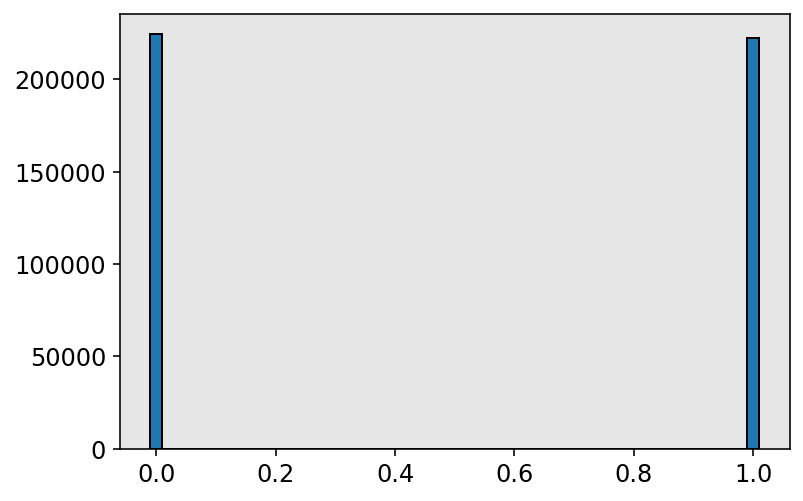

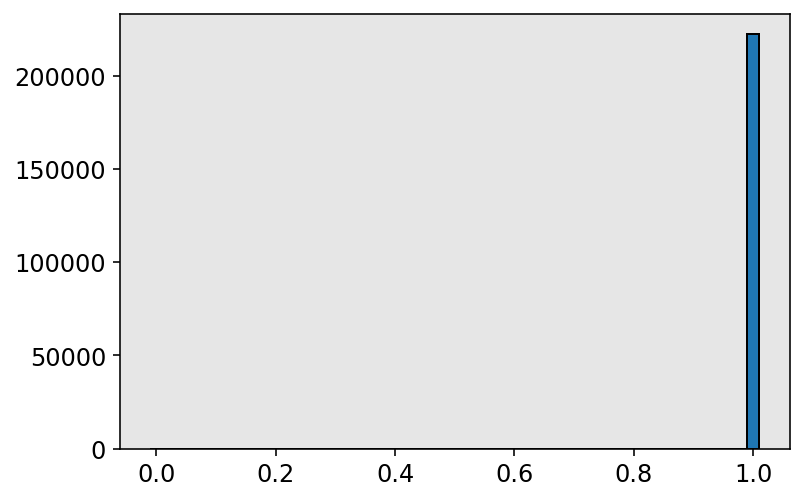

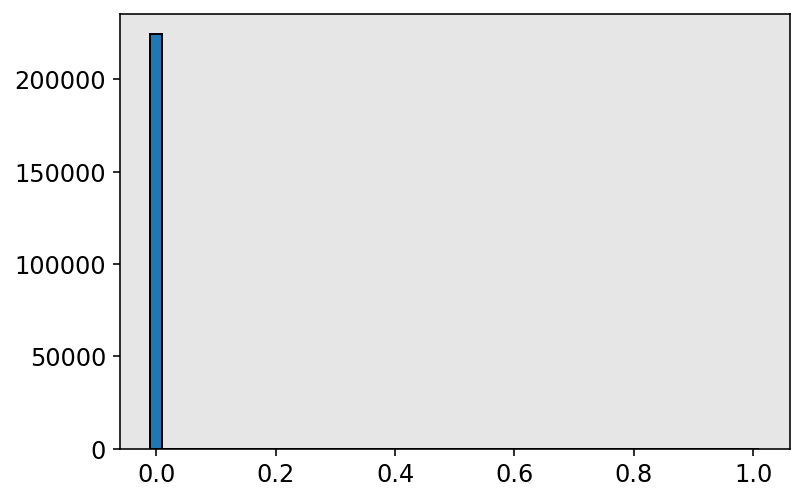

In [4]:
#show us the whole dataset
plt.hist(y_train,bins=[-0.01,0.01,0.99,1.01],edgecolor='k')

#show us the flash data
plt.figure()
plt.hist(y_train[idx_flash],bins=[-0.01,0.01,0.99,1.01],edgecolor='k')

#show us the no flash data
plt.figure()
plt.hist(y_train[idx_noflash],bins=[-0.01,0.01,0.99,1.01],edgecolor='k')

Now that things look to be working properly, lets make the histogram of brightness temperatures. The expectation is that images with flashes in them will have generally colder minimum brightness temperatures since they will likely have stronger storms (on average). 

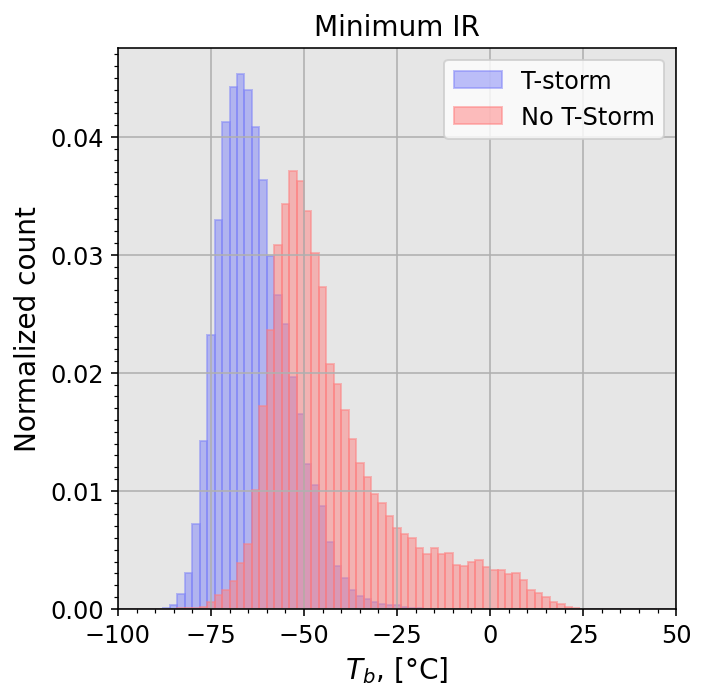

In [5]:
#this is something to help make the ticks show up where I want them 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#this is an array of bins I wish to do the histogram with, in degC
xbins = np.arange(-100,50,2)
#some colors I like. The order of ratios is [Red,Green,Blue]
r = [255/255,127/255,127/255]
b = [126/255,131/255,248/255]

#make figure  
fig = plt.figure(figsize=(5,5))
#set background color to white so we can copy paste out of the notebook if we want 
fig.set_facecolor('w')

#get axis for drawing
ax = plt.gca()

#use matplotlib histogram function 
ax.hist(X_train[idx_flash,0],density=True,bins=xbins,color=b,alpha=0.5,zorder=0,label='T-storm',edgecolor=b)
ax.hist(X_train[idx_noflash,0],density=True,bins=xbins,color=r,alpha=0.5,zorder=0,label='No T-Storm',edgecolor=r)

#add title and axis labels 
ax.set_title('Minimum IR')
ax.set_ylabel(r'Normalized count')
ax.set_xlabel("$T_{b}$, [$\degree$C]")
#set tick locations 
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))
#force xlimit
ax.set_xlim([-100,50])
#turn grid on 
ax.grid('on')
#draw legend
ax.legend()

plt.tight_layout()

Great! It follows our expectation. While there is considerable overlap between the two classes, there does seem to be a good decision boundary to seperate the two. Let's start out by training a logistic regression first. 

#### Step 3: Intialize model

Like i mentioned in the background, to initialize we can use the ```()``` after the model name. This is also where you can choose various hyperparameters. For now, just leave it empty, it will use the default parameters, which is a good place to start

In [6]:
#load model from sklearn
from sklearn.linear_model import LogisticRegression

#initialize
model = LogisticRegression()

print(model)

LogisticRegression()


#### Step 4: Train your ML model! 

This is it, we have finally made it to actually doing some machine learning, are you ready? I am! So let's go!

In [7]:
model = model.fit(X_train,y_train)

<img src="../images/congrats.gif" width="400" height="200" class="center" />

Thats it! Congrats, you have offically trained your first ML model. I know, it seems a bit underwelming because there is no fanfare from python, but to make you feel better enjoy the gif. After you are done celebrating, time to move on to evaluating how well it did!

#### Step 5: Evaluate your ML model

In order to evaluate your model, we will need the predictions of the model on the validation dataset. We will use the ```model.predict()``` method to get a prediction value for each sample

In [8]:
yhat = model.predict(X_validate)

I name the prediction vector yhat (i.e., $\hat{y}$) to match usuall math notation. But you can name it ypred if you want. This vector is a label for each sample, so we could look at a histogram of the results, or we can calcualte some more informative metrics. 

##### a). Contingency Table: Accuracy 

To get those more informative metrics, lets get the contingency table which is:


|             | Yes | No|
| ----------- | :----: | :----: |
|    **Yes**      | Hits       | False Alarms|
|    **No**      | Misses        | Correct Nulls |

The left column is the model predictions, while the top row is the observations (true labels). Each spot in the table is filled out based on:
- if both the model and observation predict **Yes** (both predict a label of 1; which is a hit or *True Positive*)
- if the model outputs a **Yes** but the observation is **No** (model=1,obs=0; False Alarm or *False Positive*)
- if the model says **No** but the observation says **Yes** (model=0,obs=1; Miss or *False Positive*)
- if the model and the observation say **No** (model=0,obs=0; Correct Null or *True Negative*)

We have coded this up for you, so all we need to use is the function called ```get_contingency_table``` from ```gewitter_functions.py```. These functions were originall written by Dr. Lagerquist during his PhD studies, but have been adapted by me to be able to run out of the box with just the ```gewitter_functions.py``` script. 

In [9]:
from gewitter_functions import get_contingency_table

#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(y_validate,yhat)


#the function returns a dictionary (thats what the curly brackets mean) of each entry in the table. 
print(cont_table)

{'num_true_positives': 37545, 'num_false_positives': 9775, 'num_false_negatives': 6378, 'num_true_negatives': 32594}


Now that we have the contingency table, we can calculate a simple metric, accuracy. Which is:

$$ Accuracy = \frac{TruePositives + TrueNegatives}{SumOfAllCategories} \times{100}$$

for concisness, we have made a function to do this named ```get_accuracy```

In [10]:
from gewitter_functions import get_acc
accuracy = get_acc(cont_table)
print('Accuracy = {}%'.format(np.round(accuracy,0)))

Accuracy = 81.0%


81% accuracy is good! Given we only use 1 input! But as pointed out in the paper, it is good to always use more than 1 evaluation metric. 

##### b). Contingency Table: Performance Diagram

<img src="../images/Blank_Performance_Diagram.png" width="400" height="200" class="center" />

One of my favorite diagrams to gauge model skill is a performance diagram (shown above). I have added some hopefully helpful annotations that show you where better performing models (top-right) and worse performing models (bottom left,top left or bottom right) show up on the diagram. 

To make this diagram we need to calculate 2 variables, the Probability of Detection (POD; y-axis) and Success Ratio (SR; x-axis), both that are calcualted from the contingency table. 

$$ \mathrm{POD} = \frac{TruePositives}{TruePositives + FalseNegatives} $$

$$ \mathrm{SR} = \frac{TruePositives}{TruePositives + FalsePositives} $$

One perk of this diagram is that we can glean the *Critical Success Index* (CSI) from the same diagram. CSI is formulated as: 

$$ \mathrm{CSI} = \frac{TruePositives}{TruePositives + FalsePositives + FalseNegatives} $$ 

What is great about the performance diagram is that it helps us evaluate ML tasks that might have unbalanced data. By unbalanced data, I mean if the scenario we are trying to predict is rare (e.g., hail, tornaodes). What happens in rare scenarios is that the data naturally have a ton of Null cases, so some metrics that consider TrueNegatives in the numerator (e.g., Accuracy) might be inflated. 

We have included the calcualtion of these parameters as functions as well ```get_pod```, ```get_sr```, ```csi_from_sr_and_pod```.


In [11]:
from gewitter_functions import get_pod,get_sr,csi_from_sr_and_pod
pod = get_pod(cont_table)
sr = get_sr(cont_table)
csi = csi_from_sr_and_pod(sr,pod)

print('POD:{}, SR:{}, CSI:{}'.format(np.round(pod,2),np.round(sr,2),np.round(csi,2)))

POD:0.85, SR:0.79, CSI:0.7


Now that we have our calculated values, you could put these in a table, or you could put it on the performance diagram. We made a function to make the performance diagram axis for us, named ```make_performance_diagram```

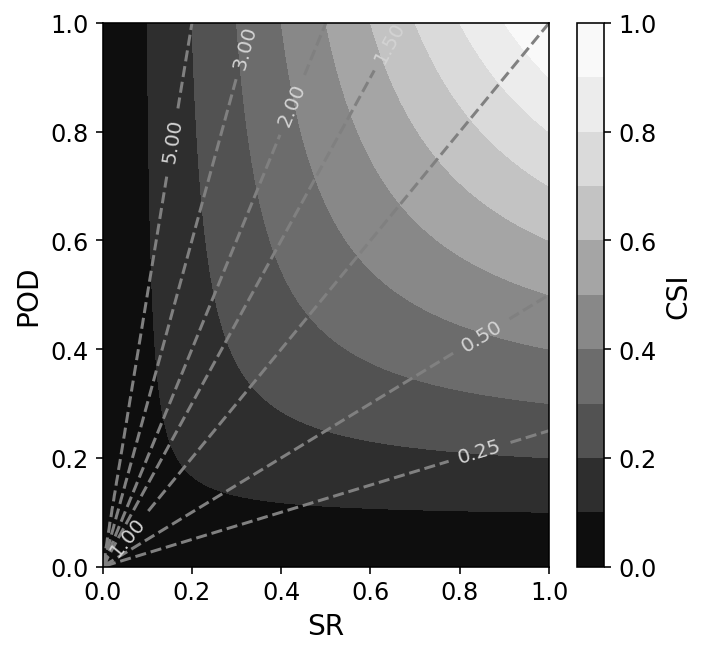

In [12]:
from gewitter_functions import make_performance_diagram_axis
ax = make_performance_diagram_axis()

the function returns the axis (```ax```) so we can plot on it. 

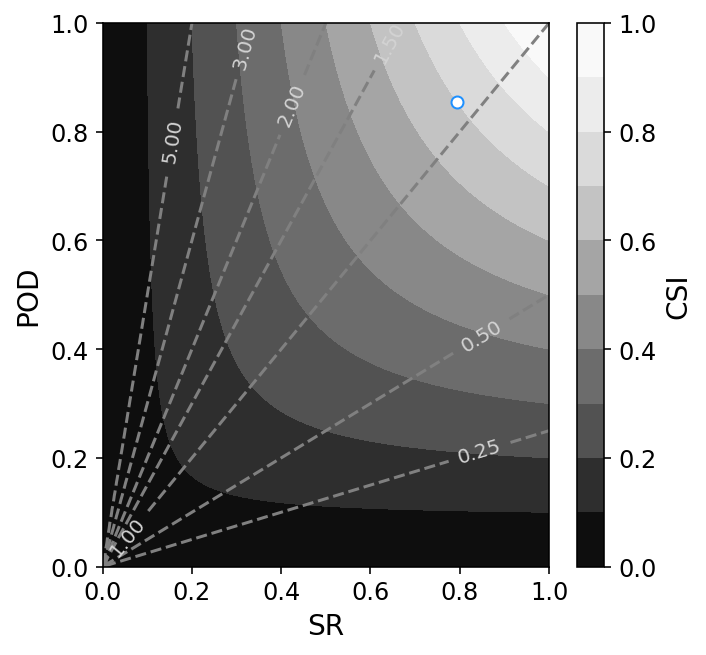

In [13]:
ax = make_performance_diagram_axis()
ax.plot(sr,pod,'o',color='dodgerblue',markerfacecolor='w');

and BAM. You have plotted your model's performance on the performance diagram. Turns out this model is doing very well, with a large POD and SR and is near the center line. 

#### Step 6: Save your trained model

Sometimes loading the training dataset and re-training the model each time can be cumbersome. There is a way to save the trained models. We will use the python ```joblib``` package to do this. 

**Notes:** 

1. Storage effciency: While most of the models in sklearn can be stored in a decent file size, your random forest model could become large (on the order of 1 GB). I know a GB is not alot of space nowadays, but it is important to note. This is also why the trained random forest from the paper is not found in the ```datasets``` folder.
2. Keep note of your ```sklearn``` version: ```joblib``` will load the model to the syntax of the ```sklearn``` that it is saved with. So if you are getting some odd error with ```sklearn``` while loading the saved model, check to make sure the version hasnt changed. 


In [15]:
import joblib
name = 'LgR.pkl'
start_path = '../datasets/sklearnmodels/classification/onefeature/'
savefile = open(start_path + name,'wb')
joblib.dump(model, savefile, 9) #the 9 here is the highest compression. Slows the time of saving/loading but saves disk space

#### Step 7: Load a saved model

Now that you have it saved, if you need to load it do the following:

In [16]:
import joblib
name = 'LgR.pkl'
start_path = '../datasets/sklearnmodels/classification/onefeature/'
#notice the change from wb to rb 
savefile = open(start_path + name,'rb')
#notice the change from dump to load 
model = joblib.load(savefile)
print(model)

LogisticRegression()


In the next notebook we will look at the Regression problem. If you want to continue on with the classification, check out Notebook 6. 